## Model Characteristics

Single max drug effect for both antibiotics (consider changing to seperate drug effects)\
Seperate EC_50 for each antibiotic\
No antibiotic period = 48 hours.  This is the time period when both sensitive and resistant bacteria grow unopposed.\
Vancomycin initial treatment duration = 72 hours at which point it is discontinued and Linezolid started.\
Linezolid continue for 96 hours.  Total sim time = 250 hours\
Vancomycin dosing 500 mg q 12 hours\
Linezolid dosing 800 mg q 8 hours


Linezolid is bacteriostatic\
Vancomycin is bacteriostatic or bactericidal


Sim function called with EC_50 for vancomycin and linezolid

Notes on arguements for solve_ivp:\

dense_output refers to whether to compute a continuous solution.  takes a bool, default = False


Key points in the solution:
Initial conditions:
Sensitive bacteria: 2.00
Resistant bacteria: 2.00

At the start of vancomycin treatment (t=48h):
Sensitive bacteria: 288185.27
Resistant bacteria: 289921.12

At the end of vancomycin treatment (t=120h):
Sensitive bacteria: 154948.96
Resistant bacteria: 529334.61

At the end of linezolid treatment (t=216h):
Sensitive bacteria: 54401.27
Resistant bacteria: 722990.30

Final values:
Sensitive bacteria: 62978.43
Resistant bacteria: 836858.51


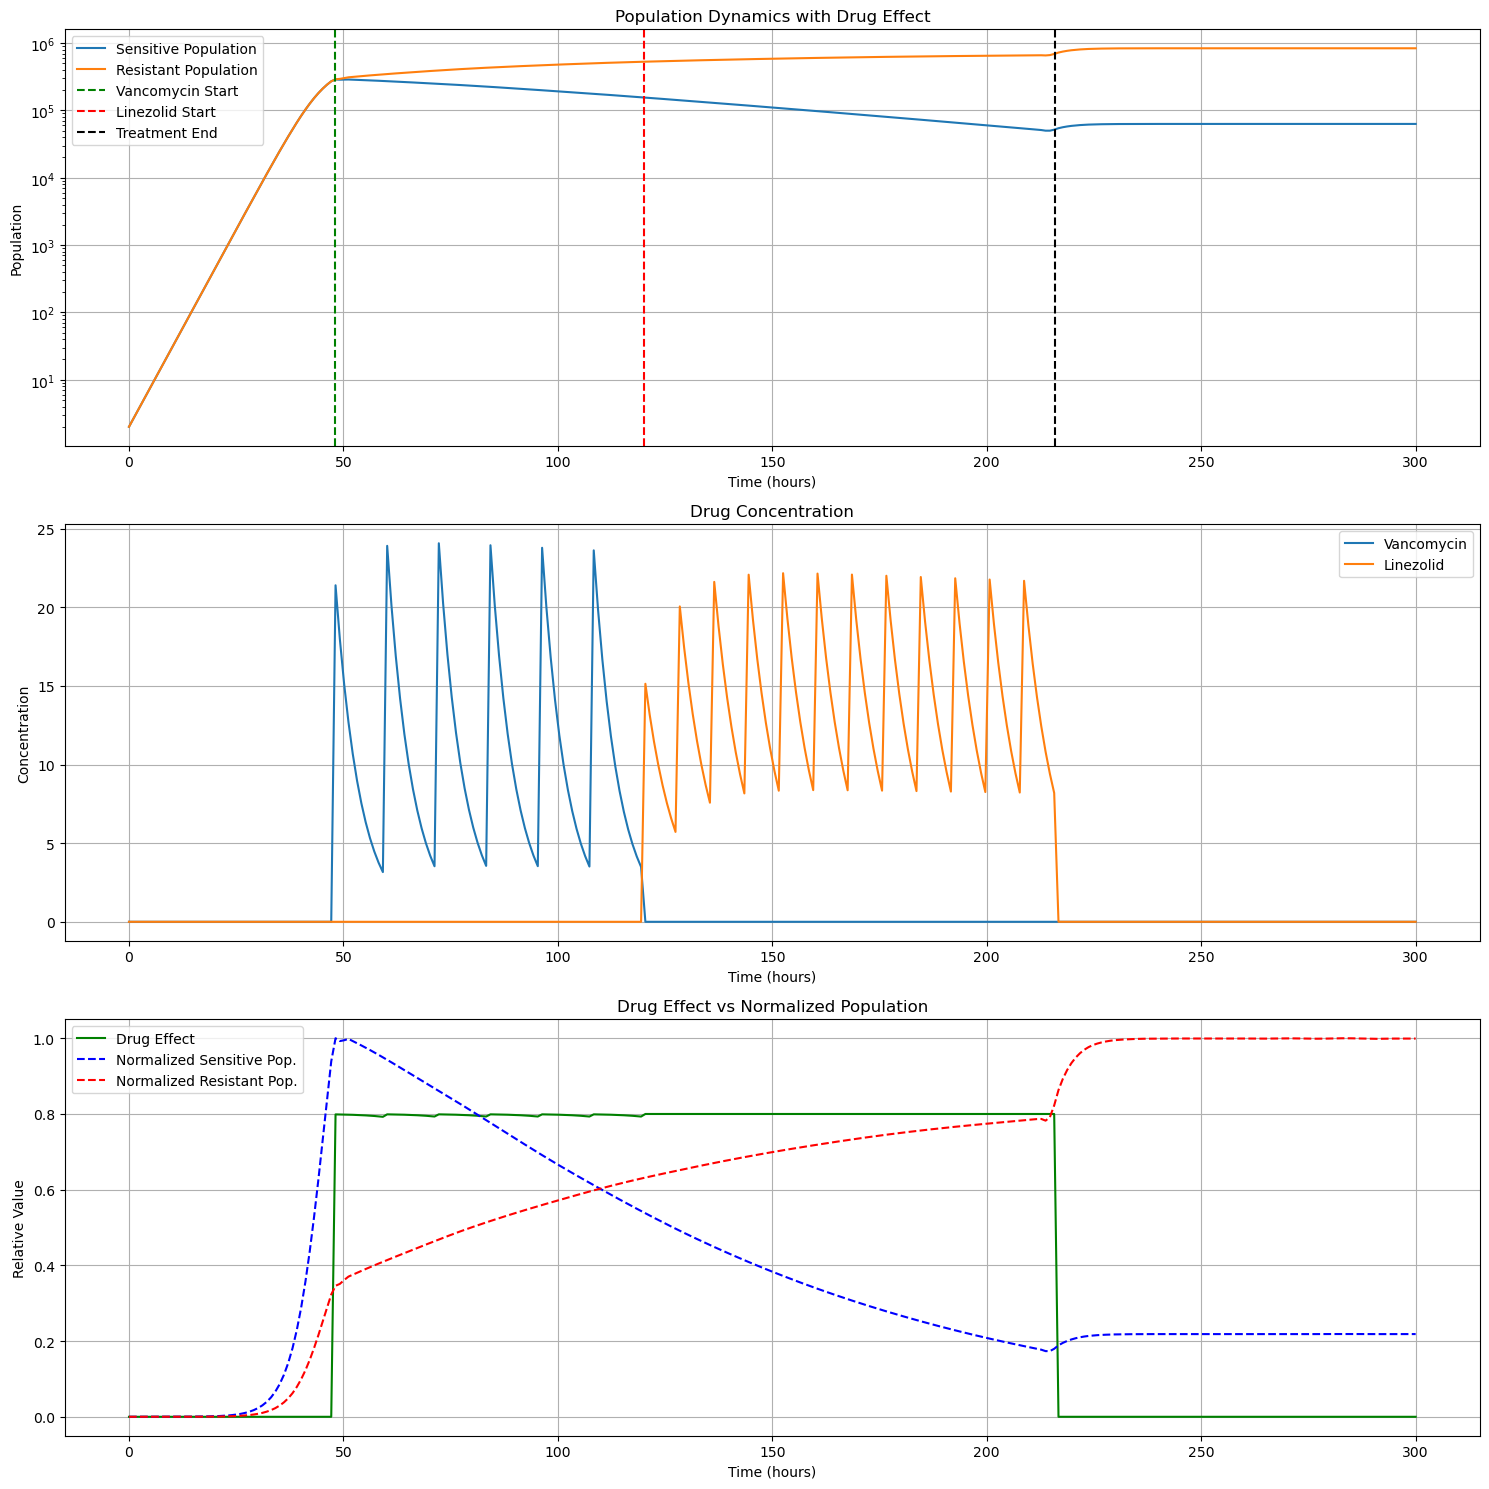

In [32]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

# [Previous helper functions remain unchanged]
'''
def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age)*weight/(72*sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel
'''
# Calculate elimination rates
# Calculate Elimination Rates
vanco_half_life = 4  # hours(normal kidney: 4 - 6 hours)
linez_half_life = 5  # hours(normal kidney: 5 - 7 hours)
ke_vanco = np.log(2) / vanco_half_life
ke_linez = np.log(2) / linez_half_life

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    EC_50_vanco, 
    EC_50_linezolid,
    initial_sensitive=2, 
    initial_resistant=2, 
    no_drug_period=48,        
    vancomycin_duration=72,   
    linezolid_duration=96,    
    total_simulation_time=300
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration
    
    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    '''
    sCr = 1.3
    Age = 60
    weight = 70
    '''
    V_vancomycin = V_linezolid = 50
    

    # Calculate Elimination Rates
    vanco_half_life = 4  # hours(normal kidney: 4 - 6 hours)
    linez_half_life = 5  # hours(normal kidney: 5 - 7 hours)
    ke_vanco = np.log(2) / vanco_half_life
    ke_linez = np.log(2) / linez_half_life
    '''
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)
    '''
    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 1100  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, ke_linez, tau_linezolid, 
        linez_start, linez_end
    )

    # Population Dynamics Parameters
    rho_sensitive = 0.3
    rho_resistant = 0.3
    delta_sensitive = 0.03
    delta_resistant = 0.03
    k = 10e5
    max_drug_effect = 0.8
   

    def population_ode(t, r):
        S, R = r
        # Get individual drug concentrations at time t
        vanco_conc = np.interp(t, time, conc_vancomycin)
        linez_conc = np.interp(t, time, conc_linezolid)
        
        # Calculate drug effects - only one drug is active at any time
        if vanco_start <= t < vanco_end:
            drug_effect = max_drug_effect * (vanco_conc / (vanco_conc + EC_50_vanco))
        elif linez_start <= t <= linez_end:
            drug_effect = max_drug_effect * (linez_conc / (linez_conc + EC_50_linezolid))
        else:
            drug_effect = 0
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - drug_effect) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.8 * drug_effect) - delta_resistant * R
        
        return [dSdt, dRdt]
        
    #Solve ODE
    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=False,
        t_eval=time
    )

    # Calculate drug effects over time for plotting
    drug_effect = np.zeros_like(time)
    for i, t in enumerate(time):
        if vanco_start <= t < vanco_end:
            drug_effect[i] = max_drug_effect * (conc_vancomycin[i] / (conc_vancomycin[i] + EC_50_vanco))
        elif linez_start <= t <= linez_end:
            drug_effect[i] = max_drug_effect * (conc_linezolid[i] / (conc_linezolid[i] + EC_50_linezolid))

    # Print key points in the solution
    print("\nKey points in the solution:")
    print(f"Initial conditions:")
    print(f"Sensitive bacteria: {solution.y[0][0]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][0]:.2f}")
    
    print(f"\nAt the start of vancomycin treatment (t={vanco_start}h):")
    idx_vanco = np.where(time >= vanco_start)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco]:.2f}")
    
    print(f"\nAt the end of vancomycin treatment (t={vanco_end}h):")
    idx_vanco_end = np.where(time >= vanco_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco_end]:.2f}")
    
    print(f"\nAt the end of linezolid treatment (t={linez_end}h):")
    idx_linez_end = np.where(time >= linez_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_linez_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_linez_end]:.2f}")
    
    print(f"\nFinal values:")
    print(f"Sensitive bacteria: {solution.y[0][-1]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][-1]:.2f}")

    # Create figure
    plt.figure(figsize=(15, 15))
    
    # Population dynamics plot
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.yscale('log')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    # Drug effect plot
    plt.subplot(3, 1, 3)
    plt.plot(time, drug_effect, 'g-', label='Drug Effect')
    plt.plot(time, solution.y[0] / np.max(solution.y[0]), 'b--', label='Normalized Sensitive Pop.')
    plt.plot(time, solution.y[1] / np.max(solution.y[1]), 'r--', label='Normalized Resistant Pop.')
    plt.title('Drug Effect vs Normalized Population')
    plt.xlabel('Time (hours)')
    plt.ylabel('Relative Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    

# Run the simulation by calling the sim function
simulate_drug_dynamics(
    EC_50_vanco=0.03, 
    EC_50_linezolid=0.0004
)

In [ ]:
import plotly
print(plotly.__version__)


In [ ]:
import ipywidgets as widgets
print(widgets.__version__)

In [18]:
import os
os.getcwd()

'C:\\Users\\Jacob\\Documents\\Projects_Python\\Antibiotic_Resistance_Models'

In [20]:
np.__version__

'1.26.4'

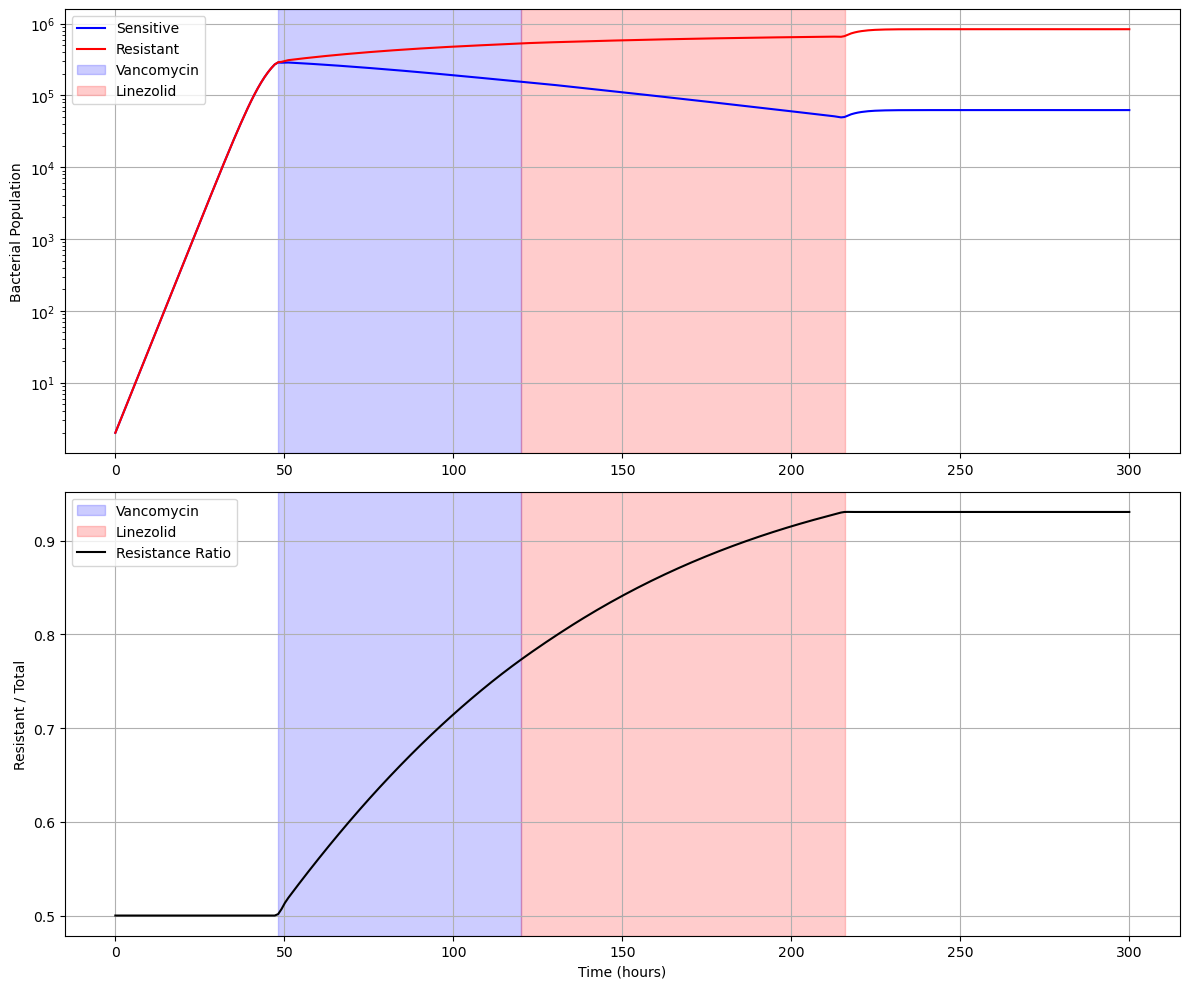

In [17]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class DrugKinetics:
    def __init__(self, half_life, volume, dose, tau):
        self.ke = np.log(2) / half_life
        self.volume = volume
        self.dose = dose
        self.tau = tau

    def calculate_concentration(self, t, start_time, end_time):
        """Calculate drug concentration at time t"""
        if t < start_time or t > end_time:
            return 0
        
        dosing_times = np.arange(start_time, min(t + self.tau, end_time), self.tau)
        return sum((self.dose / self.volume) * np.exp(-self.ke * (t - dose_time)) 
                  for dose_time in dosing_times)

class BacterialDynamics:
    def __init__(self, rho_s=0.3, rho_r=0.3, delta_s=0.03, delta_r=0.03, 
                 carrying_capacity=10e5, max_drug_effect=0.8):
        self.rho_s = rho_s  # Growth rate sensitive
        self.rho_r = rho_r  # Growth rate resistant
        self.delta_s = delta_s  # Death rate sensitive
        self.delta_r = delta_r  # Death rate resistant
        self.k = carrying_capacity
        self.max_effect = max_drug_effect

    def calculate_growth(self, S, R, drug_effect):
        """Calculate growth rates for sensitive and resistant populations"""
        total_pop = S + R
        
        dSdt = (self.rho_s * S * (1 - total_pop/self.k) * 
                (1 - drug_effect) - self.delta_s * S)
        
        dRdt = (self.rho_r * R * (1 - total_pop/self.k) * 
                (1 - 0.8 * drug_effect) - self.delta_r * R)
        
        return dSdt, dRdt

class TreatmentSimulation:
    def __init__(self, 
                 EC50_vanco, 
                 EC50_linez,
                 treatment_schedule,
                 initial_conditions=(2, 2)):
        
        self.vanco = DrugKinetics(half_life=4, volume=49, dose=500, tau=12)
        self.linez = DrugKinetics(half_life=5, volume=50, dose=800, tau=8)
        self.bacteria = BacterialDynamics()
        
        self.EC50_vanco = EC50_vanco
        self.EC50_linez = EC50_linez
        self.schedule = treatment_schedule
        self.initial = initial_conditions
        
    def drug_effect(self, t, vanco_conc, linez_conc):
        """Calculate combined drug effect at time t"""
        if self.schedule['vanco_start'] <= t < self.schedule['vanco_end']:
            return self.bacteria.max_effect * (vanco_conc / (vanco_conc + self.EC50_vanco))
        elif self.schedule['linez_start'] <= t <= self.schedule['linez_end']:
            return self.bacteria.max_effect * (linez_conc / (linez_conc + self.EC50_linez))
        return 0

    def system_ode(self, t, y):
        """Define the system of ODEs"""
        S, R = y
        
        vanco_conc = self.vanco.calculate_concentration(
            t, self.schedule['vanco_start'], self.schedule['vanco_end'])
        linez_conc = self.linez.calculate_concentration(
            t, self.schedule['linez_start'], self.schedule['linez_end'])
        
        effect = self.drug_effect(t, vanco_conc, linez_conc)
        return self.bacteria.calculate_growth(S, R, effect)

    def simulate(self, total_time, time_points=None):
        """Run the simulation"""
        if time_points is None:
            time_points = np.linspace(0, total_time, total_time)
            
        solution = solve_ivp(
            self.system_ode,
            [0, total_time],
            self.initial,
            t_eval=time_points,
            method='RK45'
        )
        
        return solution, time_points

def plot_results(time, solution, schedule):
    """Create visualization of simulation results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Population dynamics
    ax1.semilogy(time, solution.y[0], 'b-', label='Sensitive')
    ax1.semilogy(time, solution.y[1], 'r-', label='Resistant')
    
    # Add treatment period indicators
    for ax in [ax1, ax2]:
        ax.axvspan(schedule['vanco_start'], schedule['vanco_end'], 
                  alpha=0.2, color='blue', label='Vancomycin')
        ax.axvspan(schedule['linez_start'], schedule['linez_end'], 
                  alpha=0.2, color='red', label='Linezolid')
    
    ax1.set_ylabel('Bacterial Population')
    ax1.legend()
    ax1.grid(True)
    
    # Population ratio
    ratio = solution.y[1] / (solution.y[0] + solution.y[1])
    ax2.plot(time, ratio, 'k-', label='Resistance Ratio')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Resistant / Total')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

# Example usage:
schedule = {
    'vanco_start': 48,
    'vanco_end': 120,
    'linez_start': 120,
    'linez_end': 216
}

sim = TreatmentSimulation(
    EC50_vanco=0.03,
    EC50_linez=0.0004,
    treatment_schedule=schedule
)

solution, time = sim.simulate(300)
plot_results(time, solution, schedule)
plt.show()